# Self Corrective RAG
**Control Flow Steps**

1. **Routing**: Each user question is directed to the appropriate retrieval method—either a vector store or web search.

2. **Vector Store Retrieval**:
   - If chosen, the LLM retrieves documents from the vector store.
   - It grades the documents for relevancy.

3. **Answer Generation**:
   - If the retrieved content is relevant, the LLM generates an answer.

4. **Hallucination Check**:
   - The LLM verifies the generated answer for accuracy and relevance.
   - If the answer passes the check, it is shown to the user.

5. **Fallback via Web Search**:
   - If the retrieved document is not relevant or the answer is unsatisfactory, the process switches to web search for better context.

This flow allows your app to iteratively refine responses, correct errors, and enhance output quality.


In [2]:
! pip install beautifulsoup4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.3/187.3 kB 1.3 MB/s eta 0:00:0000:01:00:01


In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_ollama import OllamaEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import AzureChatOpenAI

# --- Create an index of documents ---
    
urls = [
    "https://blog.langchain.dev/top-5-langgraph-agents-in-production-2024/",
    "https://blog.langchain.dev/langchain-state-of-ai-2024/",
    "https://blog.langchain.dev/introducing-ambient-agents/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = InMemoryVectorStore.from_documents(
    documents=doc_splits,
    embedding=OllamaEmbeddings(model="mxbai-embed-large"),
)
retriever = vectorstore.as_retriever()

# Retrieve the relevant documents
results = retriever.invoke(
    "What are 2 LangGraph agents used in production in 2024?")
    
print("Results: \n", results)

Results: 
 [Document(id='07e490d3-2e35-4693-80c5-c50052259566', metadata={'source': 'https://blog.langchain.dev/top-5-langgraph-agents-in-production-2024/', 'title': 'Top 5 LangGraph Agents in Production 2024', 'language': 'en'}, page_content='Top 5 LangGraph Agents in Production 2024\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to content\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nCase Studies\n\n\n\n\nIn the Loop\n\n\n\n\nLangChain\n\n\n\n\nDocs\n\n\n\n\nChangelog\n\n\n\n\n\nSign in\nSubscribe\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTop 5 LangGraph Agents in Production 2024\n\n3 min read\nDec 31, 2024'), Document(id='d18a1fe2-62db-4f79-bd01-3631db8670af', metadata={'source': 'https://blog.langchain.dev/top-5-langgraph-agents-in-production-2024/', 'title': 'Top 5 LangGraph Agents in Production 2024', 'language': 'en'}, page_content='2024 was the year that agents started to work in production. Not the wide-ranging, fully autonomous agen

As previously outlined, the LLM evaluates the relevance of the documents retrieved from the index. This can be guided using a system prompt structured as follows:

In [4]:
# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relavant to the question, 'yes' or 'no'"
    )

# LLM with function call
llm = AzureChatOpenAI(model="gpt-4o", azure_deployment="gpt-4o", api_version="2024-10-21", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to
a user question.
If the document contains keyword(s) or semantic meaning related to the
question, grade it as relevant.
Give a binary score of 'yes' or 'no' to indicate whether the document is
relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", """Retrieved document: \n\n {document} \n\n User question:
         {question}"""),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "highly controllable agents"
docs = retriever.invoke(question)
docs_txt = docs[0].page_content # as an example
retrieval_grader.invoke({"question": question, "document": docs_txt})

GradeDocuments(binary_score='yes')

Observe how Pydantic or Zod is used to define the binary decision output, enabling programmatic routing to the appropriate node in the control flow.

LangSmith provides a visual trace of the logic flow across the nodes mentioned earlier.

Begin by testing how the system behaves when the input question cannot be answered using the documents in the index.

Use LangGraph to build, execute, and debug the complete control flow. A `transform_query` node is included to rephrase the input query in the following example, allowing the web search to retrieve more relevant results.

Finally, configure the web search tool and run the graph with an out-of-context question. The LangSmith trace confirms that the web search tool was triggered as a fallback to gather useful information before the LLM produced its final response.


In [7]:
from typing import List, TypedDict

from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import END, StateGraph, START

from retrieve_and_grade import retrieval_grader
from retrieve_and_grade import retriever
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain import hub # prompt
from utils import graph_to_image

prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = AzureChatOpenAI(model="gpt-4o", azure_deployment="gpt-4o", api_version="2024-10-21", temperature=0)

rag_chain = prompt | llm | StrOutputParser()

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

# --- Create the graph ---

web_search_tool = DuckDuckGoSearchRun()

class GraphState(TypedDict):
    """
    Represents the state of the graph.
    
    Attributes:
        question: question
        generation: LLM generation
        web_Search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state.

    Returns:
        state (dict): New key added to state, documents that contains retrieved documents.
    """
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate answer
    
    Args:
        state (dict): The current graph state.
        
    Returns:
        state (dict): New key added to state, generation, that contains the LLM generation.
    """
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state.
    
    Returns:
        state (dict): Updates documents key with only filtered relevant documents.
    """

    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("--- GRADE: DOCUMENT RELEVANT ---")
            filtered_docs.append(d)
        else:
            print("--- GRADE: DOCUMENT NOT RELEVANT ---")
            web_search = "Yes" \
            
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state.
    
    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state.
    
    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("--- WEB SEARCH ---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

# Edges

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    
    Args:
        state (dict): The current graph state
        
    Returns:
        str: Binary decision for next node to call
    """

    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        return "generate"
    
# Graph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generate
workflow.add_node("transform_query", transform_query) # transform_query
workflow.add_node("web_search_node", web_search) # web_search

# BUild graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

/home/roberto/Documents/langchain/.env/lib/python3.12/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Graph image saved to ../img/retrieve_and_grade_graph.png


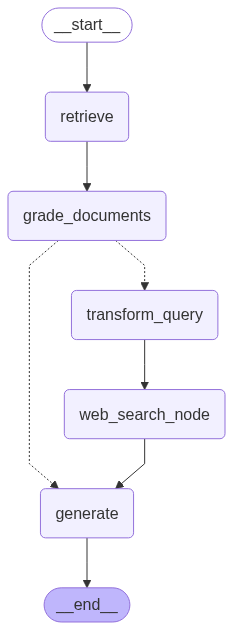

In [8]:
graph_to_image(app, "retrieve_and_grade_graph.png")

Let's go back to the [main file](../README.md#preproduction)